The data used is from the publication of [Yildiz & Stirling, 2021](https://doi.org/10.1016/j.gete.2020.100219), that is publicly available via FigShare (see `data_loader.py`).

In [1]:
from data import data_loader, data_cleaner
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
# Import data from figshare and clean it
collection = data_loader.FigshareCollection(collection_id=5312786)
collection.download_all_files(root_dir="data\\raw")
data_cleaner.clean_data("data\\raw", "data\\processed")

Found 6 articles in collection 5312786.

Processing Article ID: 13765333 - Title: PLEXUS@NGIF__Heat_Injection_Hydrological_measurements
    Saved to data\raw\PLEXUS@NGIF_Suction_Filtered_20190718_20190912.csv
    Saved to data\raw\PLEXUS@NGIF_VWC_Filtered_20190718_20190912.csv

Processing Article ID: 13766281 - Title: PLEXUS@NGIF__Heat_Injection_Water_flux
    Saved to data\raw\PLEXUS@NGIF_Drainage_15min_20190718_20190912.csv
    Saved to data\raw\PLEXUS@NGIF_WaterFlux_24h_20190718_20190912.csv

Processing Article ID: 13767142 - Title: PLEXUS@NGIF__Heat_Injection_Thermal_conductivity
    Saved to data\raw\PLEXUS@NGIF_ThermalConductivity_3h_20190718_20190912.csv

Processing Article ID: 13768768 - Title: PLEXUS@NGIF__Heat_Injection_Soil_temperature
    Saved to data\raw\PLEXUS@NGIF_SoilTemp_20190718_20190912.csv

Processing Article ID: 13768939 - Title: PLEXUS@NGIF__Heat_Injection_Heat_flux
    Saved to data\raw\PLEXUS@NGIF_HeatFlux_20190718_20190912.csv

Processing Article ID: 13761727 

<Axes: >

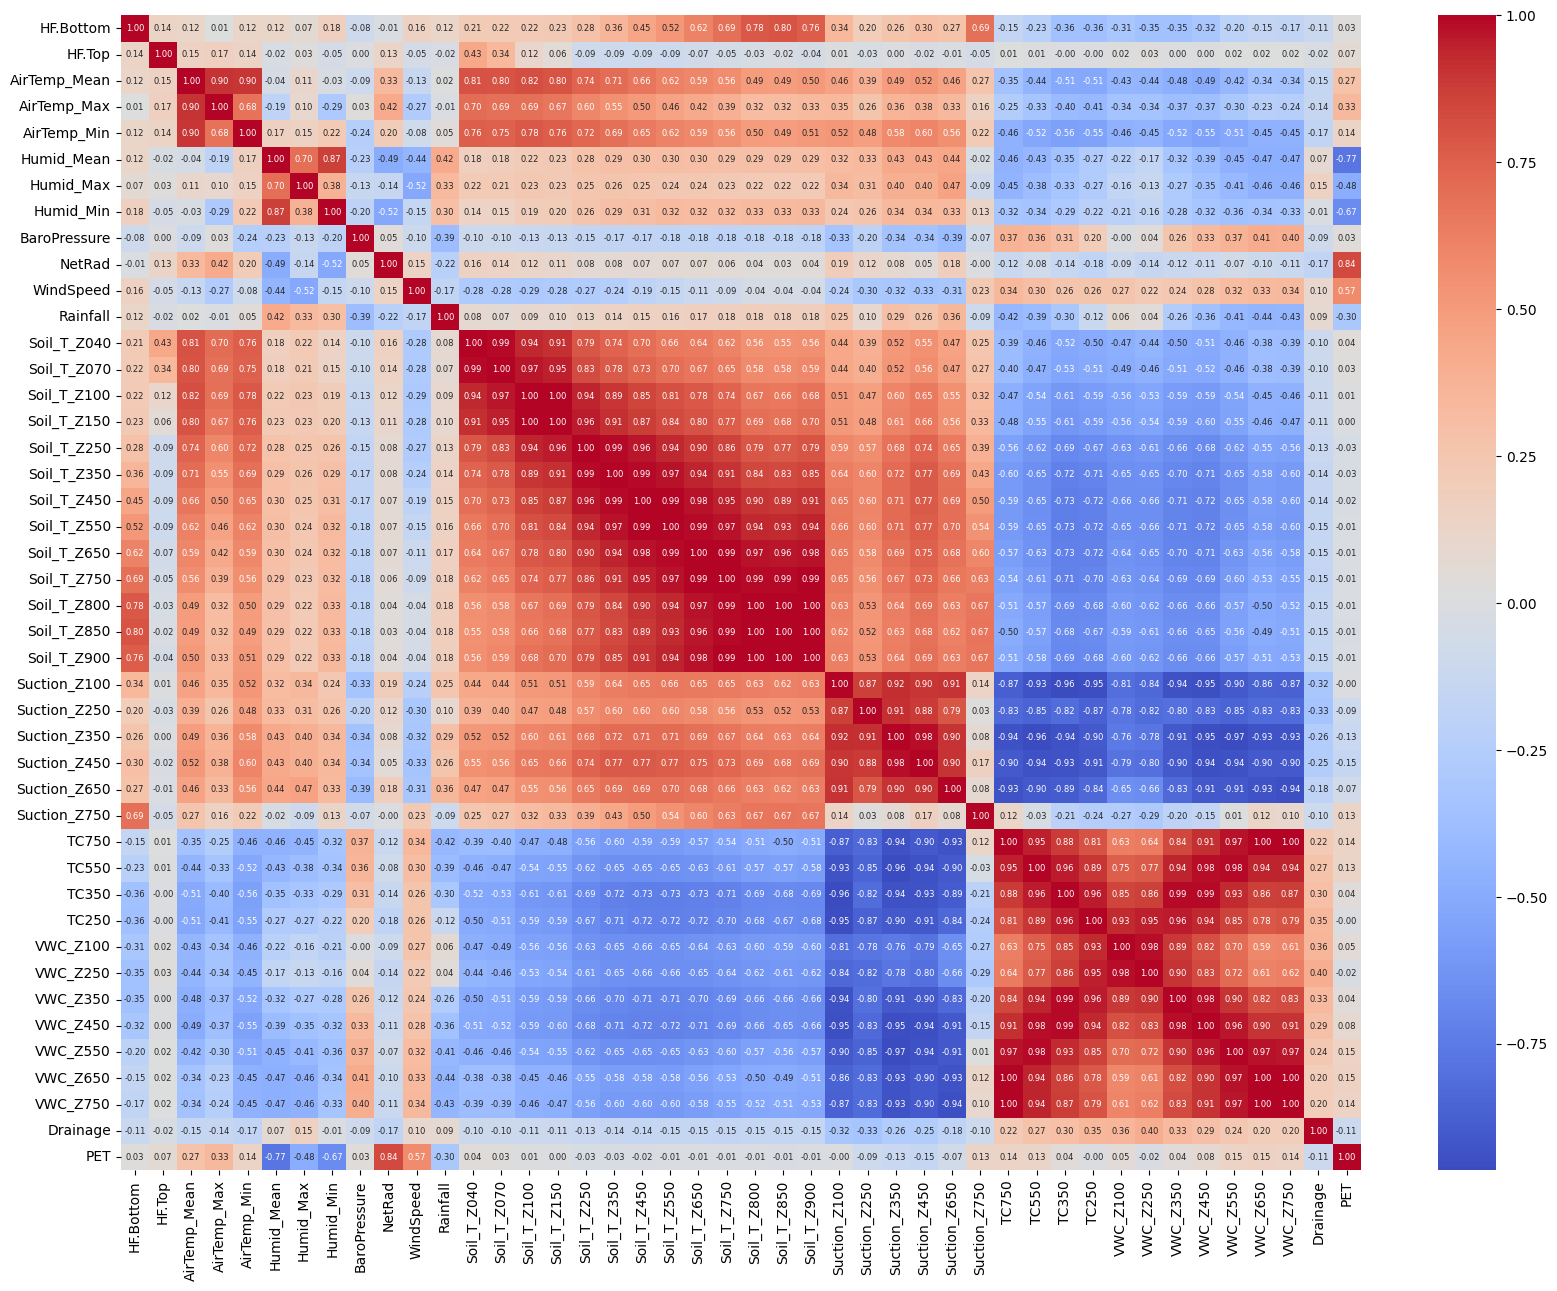

In [ ]:
# Compute correlation matrix
df_with_date = pd.read_csv("data\\processed\\merged_data.csv", parse_dates=['Time'])
df = df_with_date.drop(columns=['Time'])
corr = df.corr()

# Plot correlation matrix
plt.figure(figsize=(20, 15))
sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={"size": 6}, cmap="coolwarm")

To explore further, a linear regression between some parameters and soil temperature and volumetric water content is performed.

In [10]:
soil_temp_cols = [col for col in df.columns if col.startswith('Soil_T')]
vwc_cols = [col for col in df.columns if col.startswith('VWC')]

# For soil temperature regressions, use all columns except VWC columns.
other_columns_for_temp = [col for col in df.columns if col not in vwc_cols and not col.startswith('Soil_T')]

# For VWC regressions, use all columns except the soil temperature columns.
other_columns_for_vwc = [col for col in df.columns if col not in soil_temp_cols and not col.startswith('VWC')]

# Prepare lists to store regression results.
results_soil_temp = []
results_vwc = []

# Create a LinearRegression model (using default settings).
lr = LinearRegression()

# --- Linear regressions for Soil Temperatures ---
for temp_col in soil_temp_cols:
    for predictor in other_columns_for_temp:
        if predictor == temp_col:
            continue 
        X = df[[predictor]].values  # Predictor must be 2D
        y = df[temp_col].values
        lr.fit(X, y)
        r2 = lr.score(X, y)
        results_soil_temp.append({
            'Soil_Temperature': temp_col,
            'Predictor': predictor,
            'R2': r2
        })

# Convert the results to a DataFrame and sort by R² in descending order.
df_results_soil_temp = pd.DataFrame(results_soil_temp)
df_results_soil_temp = df_results_soil_temp.sort_values(by='R2', ascending=False)

print("=== Regression Results for Soil Temperatures (excluding VWC) ===")
print(df_results_soil_temp)
df_results_soil_temp.to_csv("data\\processed\\soil_temp_regressions.csv", index=False)

# --- Linear regressions for VWC ---
for vwc_col in vwc_cols:
    for predictor in other_columns_for_vwc:
        if predictor == vwc_col:
            continue
        X = df[[predictor]].values
        y = df[vwc_col].values
        lr.fit(X, y)
        r2 = lr.score(X, y)
        results_vwc.append({
            'VWC': vwc_col,
            'Predictor': predictor,
            'R2': r2
        })

df_results_vwc = pd.DataFrame(results_vwc)
df_results_vwc = df_results_vwc.sort_values(by='R2', ascending=False)

print("\n=== Regression Results for VWC (excluding Temperature) ===")
print(df_results_vwc)
df_results_vwc.to_csv("data\\processed\\vwc_regressions.csv", index=False)

=== Regression Results for Soil Temperatures (excluding VWC) ===
    Soil_Temperature     Predictor            R2
50       Soil_T_Z100  AirTemp_Mean  6.676186e-01
2        Soil_T_Z040  AirTemp_Mean  6.528829e-01
74       Soil_T_Z150  AirTemp_Mean  6.393627e-01
26       Soil_T_Z070  AirTemp_Mean  6.365797e-01
264      Soil_T_Z850     HF.Bottom  6.359368e-01
..               ...           ...           ...
311      Soil_T_Z900           PET  1.112862e-04
71       Soil_T_Z100           PET  6.480696e-05
239      Soil_T_Z750           PET  4.618948e-05
215      Soil_T_Z650           PET  3.426932e-05
95       Soil_T_Z150           PET  5.152814e-07

[312 rows x 3 columns]

=== Regression Results for VWC (excluding Temperature) ===
          VWC     Predictor        R2
162  VWC_Z750         TC750  0.994646
138  VWC_Z650         TC750  0.993091
92   VWC_Z450         TC350  0.980519
68   VWC_Z350         TC350  0.979230
115  VWC_Z550         TC550  0.969731
..        ...           ...       .